### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Filling Factor
- **ν**: Filling factor 1/3 (or 1/5, 2/5, etc.) (Laughlin state)
- **Nk**: Number of k-points must be multiple of denominator for commensurability
- **Ne = Nk * ν**: Number of electrons

### Interaction Details
- **Coulomb Interaction**: V(q) = W₀ × 1/|ql|
- **Gate Screening**: tanh(qD) (finite gate distace)
- **Landau level projection**: exp(-0.5 × q²l²) level form factor
- **Form Factor**: See arXiv.2509.07784 Eq.(A28)
- **Units**: Energy in units of W₀ = e²/ϵl

### Key Physics
- **Periodic boundary conditions**: Torus geometry
- **Momentum conservation**: Total momentum K = (K₁, K₂) is conserved
- **Ground state degeneracy**: 3-fold degenerate on torus for 1/3-filling Laughlin states

In [1]:
# Define 3×5 k-mesh (Nk=15) for 1/3 filling Laughlin state calculation
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 5          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

5

In [2]:
# Define 3×6 k-mesh (Nk=18) for 1/3 filling Laughlin state calculation

#=

k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]

# System parameters
Nk = 18         # Total number of k-points
Gk = (3, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 6          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

=#

In [3]:
# Define 9×9 k-mesh (Nk=27) for accurate Laughlin state calculation
# Note: This setup needs much more time and memory

#=

k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

# System parameters
Nk = 27          # Total number of k-points
Gk = (9, 9)      # Grid dimensions (G1_direction, G2_direction)
# Number of electrons for 1/3 filling
Ne = 9          # N electrons for this system

=#

In [4]:
# Define 6×5 k-mesh (Nk=30) for accurate Laughlin state calculation
# Note: This setup needs much more time and memory
# Note: for 10/30 filling, 36GB memory is recommended

#=

k_list = [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5;
          0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]

# System parameters
Nk = 30         # Total number of k-points
Gk = (6, 5)      # Grid dimensions (G1_direction, G2_direction)
Ne = 10         # N electrons for this system

=#

In [5]:
# Import the momentum-conserved exact diagonalization package
using MomentumED
include("Landau level triangular.jl")
using .LLT

In [6]:
# Physical parameters for the FQH system
LLT.D_l = 10.0                 # gate distance / magnetic length (D/l = 5)
LLT.W0 = 1.0                   # Interaction strength (energy unit)


# Create parameter structure for the exact diagonalization
# This contains all the system information needed for the calculation
para = EDPara(k_list = k_list, Gk = Gk, V_int = LLT.V_int_monolayer);

In [7]:
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));
length.(blocks)

15-element Vector{Int64}:
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200

In [8]:
# one-body terms are all zero in flat Landau level
scat = ED_sortedScatteringList_twobody(para);

In [9]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat; N = Neigen,
        showtime=true
    )
end

Processing block #1 with size 201, momentum 0, 0
  1.649930 seconds (1.18 M allocations: 55.257 MiB, 0.97% gc time, 222.44% compilation time)
  8.661578 seconds (6.75 M allocations: 343.707 MiB, 0.58% gc time, 130.40% compilation time)
Processing block #2 with size 200, momentum 0, 1
  0.014508 seconds (200.05 k allocations: 4.688 MiB)
  0.010889 seconds (3.29 k allocations: 1.536 MiB)
Processing block #3 with size 200, momentum 0, 2
  0.016852 seconds (200.07 k allocations: 4.688 MiB)
  0.022556 seconds (4.05 k allocations: 1.835 MiB, 38.03% gc time)
Processing block #4 with size 200, momentum 0, 3
  0.013759 seconds (200.04 k allocations: 4.688 MiB)
  0.039280 seconds (3.74 k allocations: 1.695 MiB)
Processing block #5 with size 200, momentum 0, 4
  0.023883 seconds (200.06 k allocations: 4.688 MiB)
  0.041984 seconds (3.28 k allocations: 1.536 MiB)
Processing block #6 with size 201, momentum 1, 0
  0.043071 seconds (201.70 k allocations: 4.737 MiB)
  0.045881 seconds (4.08 k allocat

In [10]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

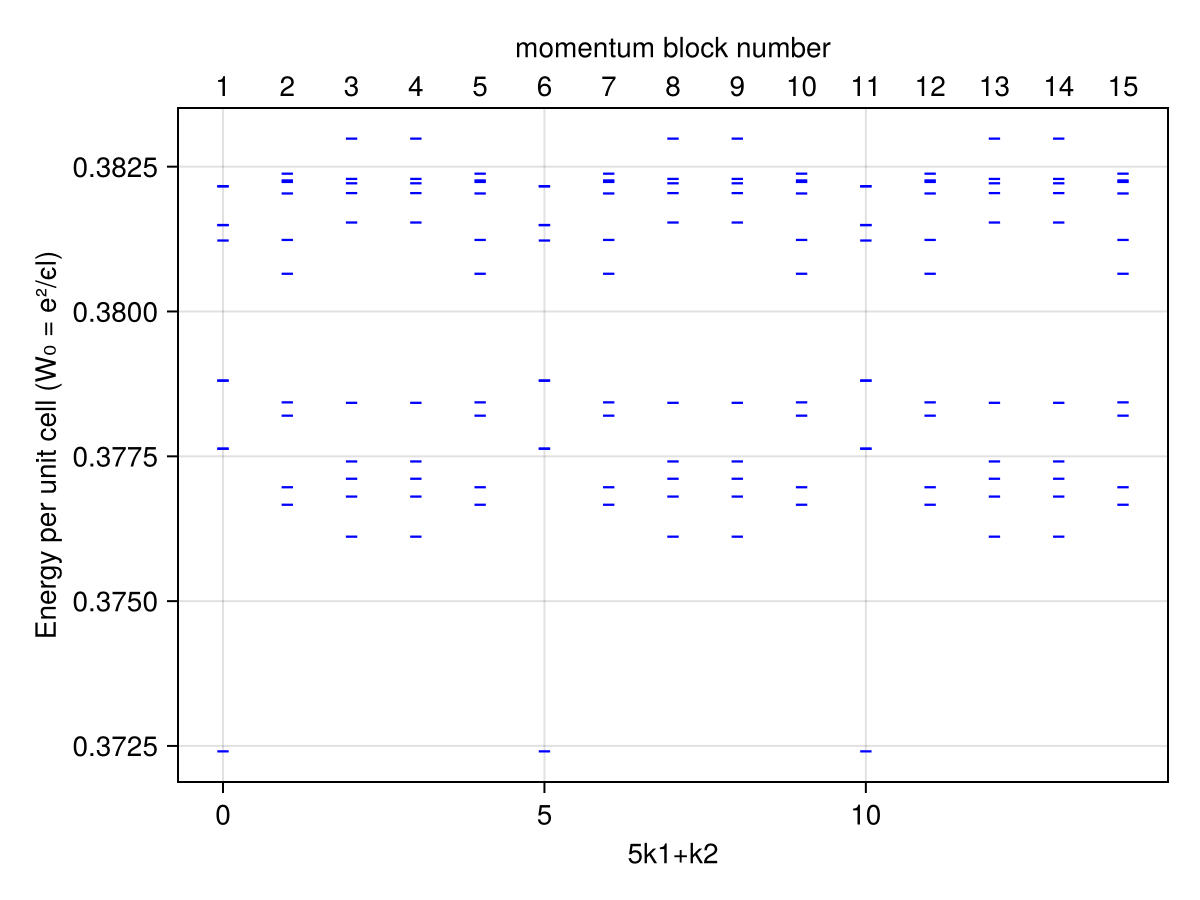

In [11]:
using CairoMakie
CairoMakie.activate!()

# Plot the energy spectrum
fig = Figure();
ax = Axis(fig[1, 1];
    xlabel = "$(Gk[2])k1+k2",
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
)
ax_top = Axis(fig[1, 1];
    xlabel = "momentum block number",
    xaxisposition = :top
)
top_ticks = ([], [])
hidespines!(ax_top)
hidexdecorations!(ax_top; label = false, ticklabels = false)
hideydecorations!(ax_top)
linkxaxes!(ax, ax_top)

# Plot energy levels for each momentum block
for i in 1:length(blocks)
    x = Gk[2] * block_k1[i] + block_k2[i]
    push!(top_ticks[1], x)
    push!(top_ticks[2], string(i))
    for e in energies[i]
        scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
    end
end
ax_top.xticks = top_ticks
fig

In [12]:
# check energies explicitly to see degeneracy.

bn = 1 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 0.3724058999924298
 0.3776313483312048
 0.3776313483312051
 0.3788066162355304
 0.3788066162355305
 0.3812251570597428
 0.3814921649936563
 0.38149216499365646
 0.3821618363102035
 0.3821618363102049

Compute and plot one-body reduced density matrix

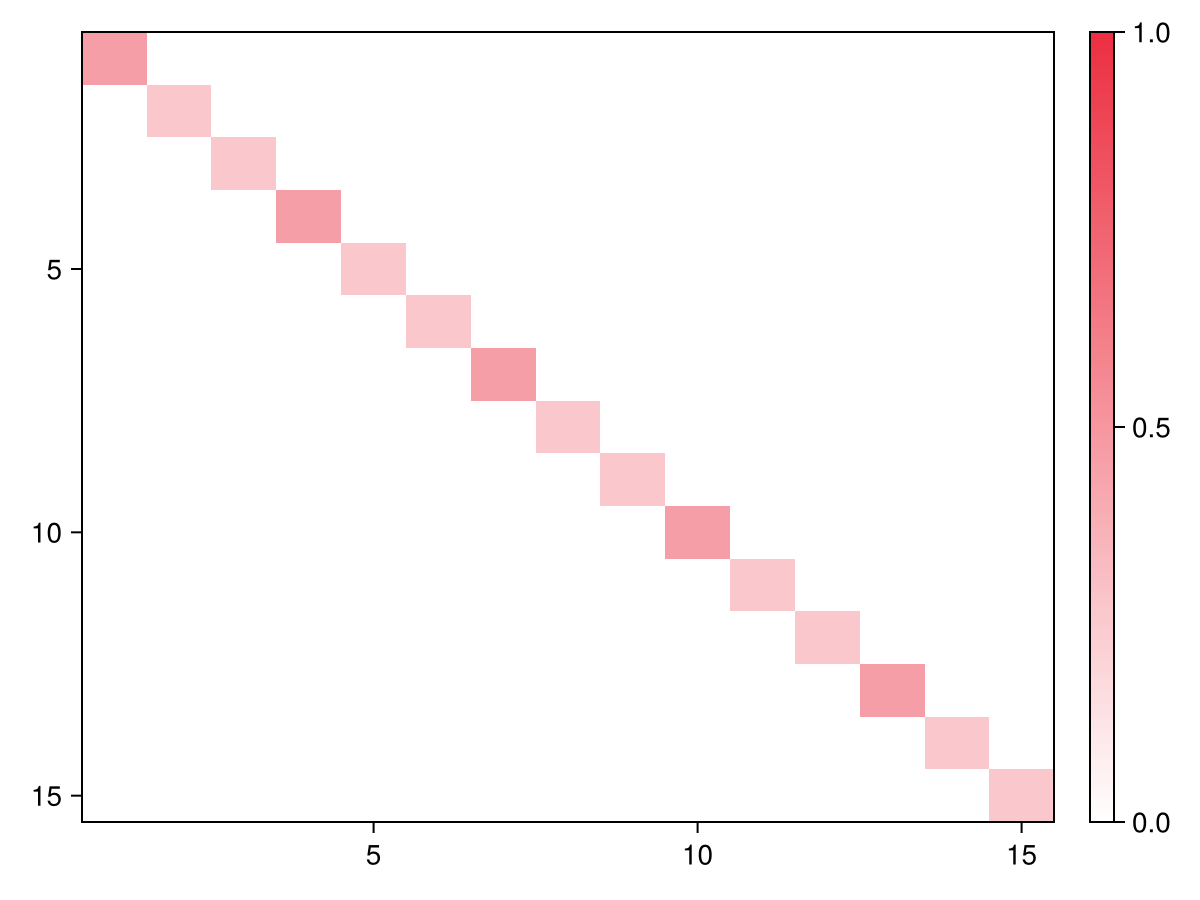

In [13]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [14]:
para.FF_inf_angle = LLT.Landau_ff_inf; # Update the form factor in the parameter

# FF_inf_angle can be added after building para. 
# However, assertion for function inputs and output is not triggered. 
# See example 2 for including FF_inf_angle during para initialization.

Landau_ff_inf (generic function with 2 methods)

In [15]:
# twist angle path for the Wilson loop integral
N_shift = 5  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
for i in 1:N_shift
    push!(path, (i/N_shift, 0.0))
end
for i in 1:N_shift
    push!(path, (1.0, i/N_shift))
end
for i in 1:N_shift
    push!(path, ((N_shift - i)/N_shift, 1.0))
end
for i in 1:N_shift
    push!(path, (0.0, (N_shift - i)/N_shift))
end
path

21-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.2, 0.0)
 (0.4, 0.0)
 (0.6, 0.0)
 (0.8, 0.0)
 (1.0, 0.0)
 (1.0, 0.2)
 (1.0, 0.4)
 (1.0, 0.6)
 (1.0, 0.8)
 ⋮
 (0.6, 1.0)
 (0.4, 1.0)
 (0.2, 1.0)
 (0.0, 1.0)
 (0.0, 0.8)
 (0.0, 0.6)
 (0.0, 0.4)
 (0.0, 0.2)
 (0.0, 0.0)

In [16]:
# If the 3 ground states are in different momentum section, 
# we can track one of them and compute its many-body Chern number

#
bn = 1
psi_before = copy(vectors[bn][1])
ED_connection_gaugefixing!(psi_before)  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4N_shift)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatteringList_twobody(para; kshift = path[i+1]);
    psi_after .= EDsolve(blocks[bn], scat_list; N = 6,
        showtime = false,
    )[2][1]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π)
#

path point #1 	 (0.2, 0.0)
Inner product: amp = 1.0000000000000016, phase = 0.2094395102393312
path point #2 	 (0.4, 0.0)
Inner product: amp = 1.0000000000000018, phase = 0.20943951023931057
path point #3 	 (0.6, 0.0)
Inner product: amp = 1.0000000000000004, phase = 0.20943951023929833
path point #4 	 (0.8, 0.0)
Inner product: amp = 0.9999999999999991, phase = 0.20943951023934543
path point #5 	 (1.0, 0.0)
Inner product: amp = 0.9999999999999988, phase = 0.20943951023931218
path point #6 	 (1.0, 0.2)
Inner product: amp = 1.0000000000000004, phase = -0.3351032163829169
path point #7 	 (1.0, 0.4)
Inner product: amp = 0.9999999999999999, phase = -0.33510321638290347
path point #8 	 (1.0, 0.6)
Inner product: amp = 0.999999999999998, phase = -0.3351032163829119
path point #9 	 (1.0, 0.8)
Inner product: amp = 0.9999999999999999, phase = -0.3351032163829113
path point #10 	 (1.0, 1.0)
Inner product: amp = 1.000000000000002, phase = -0.335103216382919
path point #11 	 (0.8, 1.0)
Inner product:

-0.3333333333333338

In [17]:
# If the 3 degenerate ground states are in the same total momentum section, 
# we can only compute the sum of the tatal connection and Chern number.

#=
bn = 4
psi_before = reduce(hcat, vectors[bn][1:3])
ED_connection_gaugefixing!(psi_before)
psi_after = similar(psi_before)

using LinearAlgebra
WilsonLoopIntegral= Vector{Float64}(undef, 4N_shift)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    if path[i+1] == (0.0, 0.0)
        psi_after. = reduce(hcat, vectors[bn][1:3])
        ED_connection_gaugefixing!(psi_after)
    else
        scat_list = ED_sortedScatteringList_twobody(para; kshift = path[i+1]);
        vecs = EDsolve(blocks[bn], scat_list; N = 10,
            showtime = false, 
        )[2][1:3]
        psi_after. = reduce(hcat, vecs)
        ED_connection_gaugefixing!(psi_after)
    end

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn],
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before. = psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π)
=#